Integrantes del equipo:
- Alonso Cañas Rico
- Hugo Jiménez García

# Parameters

In [1]:
EPOCHS = 30
LEARNING_RATE = 3e-5
BATCH_SIZE = 256
LAYERS_TO_TRAIN = 0

In [2]:
ai_generated_path = "pan24-generative-authorship-news/machines"
human_path = "pan24-generative-authorship-news/human.jsonl"

# Initial config

## Libraries

In [3]:
import os
import json
import warnings
import logging
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score, 
    brier_score_loss, fbeta_score
)

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from transformers import BertTokenizer, BertModel, AdamW

c:\Users\Hugo\git\NLP\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Device and warmings

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
warnings.filterwarnings("ignore", message=".*overflowing tokens.*")
logging.disable(logging.WARNING)

# Data

## Import data

In [6]:
model, id, text = [], [], []

# Loop through every file in the directory
for filename in os.listdir(ai_generated_path):
    # Check if the file is a JSONL file
    if filename.endswith('.jsonl'):
        filepath = os.path.join(ai_generated_path, filename)
        with open(filepath, 'r', encoding='utf-8') as jsonl_file:
            for line in jsonl_file:
                # Each line is a separate JSON object
                data = json.loads(line)
                model.append(filename)
                id.append(data['id'])
                text.append(data['text'])

df_generated = pd.DataFrame({'model': model, 'id': id, 'text': text, 'ai_generated': 1})
df_generated

,model,id,text,ai_generated
0,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Inaugural Address: President Joseph R. Biden J...,1
1,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Setting the Record Straight: Fact-Checking the...,1
2,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Joe Biden Takes the Oath of Office as 46th Pre...,1
3,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Joe Biden Takes Oath as 46th President of Unit...,1
4,alpaca-7b.jsonl,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...,Amanda Gorman's Inspiring Poem Celebrates Hope...,1
...,...,...,...,...
14126,vicgalle-gpt2-open-instruct-v1.jsonl,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,'The Disappearance of Gabby Petito' – A Compre...,1
14127,vicgalle-gpt2-open-instruct-v1.jsonl,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,"Utah State Police Search for Gabby Petito, Tra...",1
14128,vicgalle-gpt2-open-instruct-v1.jsonl,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,McKenna's Lost Friend: Debunking the Evidence ...,1
14129,vicgalle-gpt2-open-instruct-v1.jsonl,vicgalle-gpt2-open-instruct-v1/news-2021-01-01...,"""Gunshots Found in Florida Nature Preserve: A ...",1


In [7]:
id, text = [], []

with open(human_path, 'r', encoding='utf-8') as jsonl_file:
    for line in jsonl_file:
        # Each line is a separate JSON object
        data = json.loads(line)
        id.append(data['id'])
        text.append(data['text'])

df_human = pd.DataFrame({'model': 'Human', 'id': id, 'text': text, 'ai_generated': 0})
df_human

,model,id,text,ai_generated
0,Human,articles-cleaned-truncated/news-2021-01-01-202...,Inaugural Address by President Joseph R. Biden...,0
1,Human,articles-cleaned-truncated/news-2021-01-01-202...,Fact check: Biden inauguration impacted by pan...,0
2,Human,articles-cleaned-truncated/news-2021-01-01-202...,Highlights from Joe Biden's 2021 inauguration\...,0
3,Human,articles-cleaned-truncated/news-2021-01-01-202...,"Biden takes the helm, appeals for unity to tak...",0
4,Human,articles-cleaned-truncated/news-2021-01-01-202...,'The Hill We Climb': Read Amanda Gorman's inau...,0
...,...,...,...,...
1082,Human,articles-cleaned-truncated/news-2021-01-01-202...,How amateur detectives on social media helped ...,0
1083,Human,articles-cleaned-truncated/news-2021-01-01-202...,Authorities searching for missing 22-year-old ...,0
1084,Human,articles-cleaned-truncated/news-2021-01-01-202...,Univ. of Wisconsin Oshkosh student helping Gab...,0
1085,Human,articles-cleaned-truncated/news-2021-01-01-202...,Did the Internet Actually Help Find Gabby Peti...,0


In [8]:
df = pd.concat([df_generated, df_human])[['text', 'ai_generated', 'id']]
df

,text,ai_generated,id
0,Inaugural Address: President Joseph R. Biden J...,1,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
1,Setting the Record Straight: Fact-Checking the...,1,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
2,Joe Biden Takes the Oath of Office as 46th Pre...,1,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
3,Joe Biden Takes Oath as 46th President of Unit...,1,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
4,Amanda Gorman's Inspiring Poem Celebrates Hope...,1,alpaca-7b/news-2021-01-01-2021-12-31-bideninau...
...,...,...,...
1082,How amateur detectives on social media helped ...,0,articles-cleaned-truncated/news-2021-01-01-202...
1083,Authorities searching for missing 22-year-old ...,0,articles-cleaned-truncated/news-2021-01-01-202...
1084,Univ. of Wisconsin Oshkosh student helping Gab...,0,articles-cleaned-truncated/news-2021-01-01-202...
1085,Did the Internet Actually Help Find Gabby Peti...,0,articles-cleaned-truncated/news-2021-01-01-202...


## Make combinations of text pairs

In [9]:
test_size = 0.25
val_size = 0.125
_adjusted_val_size = val_size / (1 - test_size)

# Extraer el segundo y tercer segmento de los IDs
df['base_id'] = df['id'].apply(lambda x: '/'.join(x.split('/')[1:]))  # Coger los ids sin la parte que identifica al autor del fragmento de texto.

# Paso 1: Dividir los datos según los `base_id`
base_ids = df['base_id'].unique()
train_base_ids, test_base_ids = train_test_split(base_ids, test_size=test_size, random_state=1337)
train_base_ids, val_base_ids = train_test_split(train_base_ids, test_size=_adjusted_val_size, random_state=1337) 

# Crear DataFrames por conjunto
train = df[df['base_id'].isin(train_base_ids)]
val = df[df['base_id'].isin(val_base_ids)]
test = df[df['base_id'].isin(test_base_ids)]

train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print(f"train shape: {train.shape}")
print(f"val shape: {val.shape}")
print(f"test shape: {test.shape}")

train shape: (9506, 4)
val shape: (1904, 4)
test shape: (3808, 4)


In [10]:
def create_combinations_within_id(df):
    # Lista para almacenar las combinaciones de cada `base_id`
    combinations = []
    
    # Iterar sobre cada `base_id`
    for _, group in df.groupby('base_id'):
        # Filtrar textos humanos e IA dentro del grupo
        df_human = group[group['ai_generated'] == 0][['text']].reset_index(drop=True)
        df_ia = group[group['ai_generated'] == 1][['text']].reset_index(drop=True)
        
        # Producto cartesiano dentro del `base_id`
        cartesian_df = df_human.merge(df_ia, how='cross', suffixes=('_human', '_ia'))
        cartesian_df = cartesian_df.sample(frac=1).reset_index(drop=True)
        
        # Crear las dos disposiciones
        total_combinations = len(cartesian_df)
        
        half_1 = cartesian_df.iloc[:total_combinations // 2].copy()
        half_1['comment_text_1'] = half_1['text_human']
        half_1['comment_text_2'] = half_1['text_ia']
        half_1['list'] = 0  # Etiqueta 0
        
        half_2 = cartesian_df.iloc[total_combinations // 2:].copy()
        half_2['comment_text_1'] = half_2['text_ia']
        half_2['comment_text_2'] = half_2['text_human']
        half_2['list'] = 1  # Etiqueta 1
        
        # Combinar y agregar al resultado final
        balanced_df = pd.concat([half_1, half_2], ignore_index=True)
        combinations.append(balanced_df)
    
    # Concatenar todas las combinaciones y barajar
    return pd.concat(combinations, ignore_index=True).sample(frac=1).reset_index(drop=True)


In [11]:
# Generar combinaciones restringidas por `id` para cada conjunto
train = create_combinations_within_id(train)
val = create_combinations_within_id(val)
test = create_combinations_within_id(test)

In [12]:
# Print the dimensions
print(f"train shape: {train.shape} / Text on comment_text_1 is human-generated: {train['list'].value_counts()[0]} - Text on comment_text_2 is human-generated: {train['list'].value_counts()[1]}")
print(f"val shape: {val.shape} / Text on comment_text_1 is human-generated: {val['list'].value_counts()[0]} - Text on comment_text_2 is human-generated: {val['list'].value_counts()[1]}")
print(f"test shape: {test.shape} / Text on comment_text_1 is human-generated: {test['list'].value_counts()[0]} - Text on comment_text_2 is human-generated: {test['list'].value_counts()[1]}")

train shape: (8827, 5) / Text on comment_text_1 is human-generated: 4074 - Text on comment_text_2 is human-generated: 4753
val shape: (1768, 5) / Text on comment_text_1 is human-generated: 816 - Text on comment_text_2 is human-generated: 952
test shape: (3536, 5) / Text on comment_text_1 is human-generated: 1632 - Text on comment_text_2 is human-generated: 1904


# Model

In [13]:
# Tokenizador y modelo
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
individual_model = BertModel.from_pretrained(model_name)

In [14]:
for param in individual_model.parameters():
    param.requires_grad = False
if LAYERS_TO_TRAIN > 0:
    for layer in individual_model.encoder.layer[-LAYERS_TO_TRAIN:]:
        for param in layer.parameters():
            param.requires_grad = True

for param in individual_model.pooler.dense.parameters():
    param.requires_grad = True

# Verify that only the classifier layer is trainable
for name, param in individual_model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

embeddings.word_embeddings.weight: requires_grad = False
embeddings.position_embeddings.weight: requires_grad = False
embeddings.token_type_embeddings.weight: requires_grad = False
embeddings.LayerNorm.weight: requires_grad = False
embeddings.LayerNorm.bias: requires_grad = False
encoder.layer.0.attention.self.query.weight: requires_grad = False
encoder.layer.0.attention.self.query.bias: requires_grad = False
encoder.layer.0.attention.self.key.weight: requires_grad = False
encoder.layer.0.attention.self.key.bias: requires_grad = False
encoder.layer.0.attention.self.value.weight: requires_grad = False
encoder.layer.0.attention.self.value.bias: requires_grad = False
encoder.layer.0.attention.output.dense.weight: requires_grad = False
encoder.layer.0.attention.output.dense.bias: requires_grad = False
encoder.layer.0.attention.output.LayerNorm.weight: requires_grad = False
encoder.layer.0.attention.output.LayerNorm.bias: requires_grad = False
encoder.layer.0.intermediate.dense.weight: requ

In [15]:
class IndividualTransformer(torch.nn.Module):
    def __init__(self, bert_model):
        super(IndividualTransformer, self).__init__()
        self.l1 = bert_model
        self.l2 = torch.nn.Linear(768, 768)
        self.l3 = torch.nn.Dropout(0.1)
        self.l4 = torch.nn.Linear(768, 1)

    def forward(self, ids, mask, token_type_ids):
        embed = self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids).last_hidden_state[:, 0]
        embed = F.gelu(self.l3(self.l2(embed)))
        logits = self.l4(embed)
        return torch.sigmoid(logits)


model = IndividualTransformer(individual_model)
model.to(device)

IndividualTransformer(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

# Training

## Loss and optimizer

In [17]:
from transformers import AdamW

loss_fn = torch.nn.BCELoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

## Data Generators

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text_1 = dataframe.comment_text_1
        self.comment_text_2 = dataframe.comment_text_2
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        comment_text_1 = str(self.comment_text_1[index])
        comment_text_1 = " ".join(comment_text_1.split())
        comment_text_2 = str(self.comment_text_2[index])
        comment_text_2 = " ".join(comment_text_2.split())

        inputs = self.tokenizer(comment_text_1,
                                comment_text_2,
                                max_length=self.max_len,
                                padding="max_length",
                                truncation=True,
                                return_overflowing_tokens=False,
                                return_token_type_ids=True)
        return {
            'ids': torch.tensor(inputs.input_ids, dtype=torch.long),
            'mask': torch.tensor(inputs.attention_mask, dtype=torch.long),
            'token_type_ids': torch.tensor(inputs.token_type_ids, dtype=torch.long),
            'labels': torch.tensor(self.targets[index], dtype=torch.long)
          }


In [18]:
# Instancia el dataset
train_dataset = CustomDataset(dataframe=train, tokenizer=tokenizer, max_len=512)
val_dataset = CustomDataset(dataframe=val, tokenizer=tokenizer, max_len=512)
test_dataset = CustomDataset(dataframe=test, tokenizer=tokenizer, max_len=512)

In [ ]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Training and metrics methods

In [20]:
def c_at_1(targets, preds):
    """
    Calculates the C@1 metric:
    - Non-answers (predictions marked as -1) are given a score of 0.5.
    - Remaining cases are scored based on accuracy.
    
    Parameters:
        targets (np.array): Ground truth labels.
        preds (np.array): Predictions, where -1 indicates a non-answer.
    
    Returns:
        float: C@1 metric.
    """
    correct = (targets == preds)  # Boolean array for correct predictions
    unanswered = preds == -1     # Boolean array for non-answers
    
    num_correct = correct.sum()
    num_total = len(targets)
    num_unanswered = unanswered.sum()
    
    return (num_correct + num_unanswered * 0.5) / num_total

In [ ]:
# Función de entrenamiento
def train_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0

    # Use tqdm to wrap the loader for a progress bar
    for batch in tqdm(loader, desc="Training", leave=True):
        labels = batch['labels'].unsqueeze(1).to(device).float()
        batch = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        outputs = model(**batch)

        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

# Función de evaluación
def evaluate(model, loader, device):
    model.eval()
    preds, targets, probabilities = [], [], []

    with torch.no_grad():
        for batch in loader:
            labels = batch['labels'].unsqueeze(1).float()
            batch = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**batch)
            probabilities.extend(outputs.cpu().numpy())
            preds.extend(torch.round(outputs).cpu().numpy())
            targets.extend(labels.cpu().numpy())
    
    targets = np.array(targets).flatten()
    preds = np.array(preds).flatten()
    probabilities = np.array(probabilities).flatten()
    
    # Calculate metrics
    roc_auc = roc_auc_score(targets, probabilities)
    brier = brier_score_loss(targets, probabilities)
    f1 = f1_score(targets, preds)
    f05u = fbeta_score(targets, preds, beta=0.5)
    c1 = c_at_1(targets, preds)
    mean = np.mean([roc_auc, 1-brier, c1, f1, f05u])
    
    return {
        "accuracy": accuracy_score(targets, preds),
        "roc-auc": roc_auc,
        "brier": brier,
        "c@1": c1,
        "f1": f1,
        "f05u": f05u,
        "mean": mean,
    }


## Training

In [22]:
history = {
    "train_loss": [],
    "train_metrics": [],
    "val_metrics": []
}

save_path = f"models/models_individual_concatenate_embeddings/bert-base/fine_tuned_model_{EPOCHS}_epochs_{LEARNING_RATE}_lr_{LAYERS_TO_TRAIN}_layers_{BATCH_SIZE}_batch_size"

for epoch in range(EPOCHS):
    print(f"Starting Epoch {epoch + 1}/{EPOCHS}")
    print("* Training")
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn, device)

    print("* Saving model")
    _epoch_save_path = f"{save_path}_checkpoint_{epoch + 1}.pth"
    torch.save(model, _epoch_save_path)

    print("* Calculating metrics for training")
    train_metrics  = evaluate(model, train_loader, device)
    print("* Calculating metrics for validation")
    val_metrics  = evaluate(model, val_loader, device)

    history["train_loss"].append(train_loss)
    history["train_metrics"].append(train_metrics)
    history["val_metrics"].append(val_metrics)

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}")
    print("Train Metrics:")
    for metric_name, value in train_metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    print("Validation Metrics:")
    for metric_name, value in val_metrics.items():
        print(f"  {metric_name}: {value:.4f}")

Starting Epoch 1/30
* Training


Training: 100%|██████████| 35/35 [01:57<00:00,  3.35s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 1/30
Train Loss: 0.6903
Train Metrics:
  accuracy: 0.5383
  roc-auc: 0.6534
  brier: 0.2470
  c@1: 0.5383
  f1: 0.6998
  f05u: 0.5931
  mean: 0.6475
Validation Metrics:
  accuracy: 0.5379
  roc-auc: 0.6809
  brier: 0.2468
  c@1: 0.5379
  f1: 0.6995
  f05u: 0.5929
  mean: 0.6529
Starting Epoch 2/30
* Training


Training: 100%|██████████| 35/35 [01:53<00:00,  3.24s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 2/30
Train Loss: 0.6854
Train Metrics:
  accuracy: 0.5404
  roc-auc: 0.6984
  brier: 0.2448
  c@1: 0.5404
  f1: 0.7005
  f05u: 0.5942
  mean: 0.6577
Validation Metrics:
  accuracy: 0.5379
  roc-auc: 0.7215
  brier: 0.2445
  c@1: 0.5379
  f1: 0.6991
  f05u: 0.5928
  mean: 0.6614
Starting Epoch 3/30
* Training


Training: 100%|██████████| 35/35 [01:53<00:00,  3.24s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 3/30
Train Loss: 0.6809
Train Metrics:
  accuracy: 0.5415
  roc-auc: 0.7119
  brier: 0.2433
  c@1: 0.5415
  f1: 0.7010
  f05u: 0.5948
  mean: 0.6612
Validation Metrics:
  accuracy: 0.5385
  roc-auc: 0.7329
  brier: 0.2428
  c@1: 0.5385
  f1: 0.6996
  f05u: 0.5932
  mean: 0.6643
Starting Epoch 4/30
* Training


Training: 100%|██████████| 35/35 [01:52<00:00,  3.23s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 4/30
Train Loss: 0.6791
Train Metrics:
  accuracy: 0.5534
  roc-auc: 0.7225
  brier: 0.2410
  c@1: 0.5534
  f1: 0.7054
  f05u: 0.6010
  mean: 0.6683
Validation Metrics:
  accuracy: 0.5475
  roc-auc: 0.7422
  brier: 0.2404
  c@1: 0.5475
  f1: 0.7030
  f05u: 0.5979
  mean: 0.6700
Starting Epoch 5/30
* Training


Training: 100%|██████████| 35/35 [01:52<00:00,  3.22s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 5/30
Train Loss: 0.6753
Train Metrics:
  accuracy: 0.5846
  roc-auc: 0.7338
  brier: 0.2387
  c@1: 0.5846
  f1: 0.7154
  f05u: 0.6181
  mean: 0.6826
Validation Metrics:
  accuracy: 0.5877
  roc-auc: 0.7552
  brier: 0.2380
  c@1: 0.5877
  f1: 0.7191
  f05u: 0.6200
  mean: 0.6888
Starting Epoch 6/30
* Training


Training: 100%|██████████| 35/35 [01:53<00:00,  3.24s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 6/30
Train Loss: 0.6715
Train Metrics:
  accuracy: 0.5910
  roc-auc: 0.7463
  brier: 0.2367
  c@1: 0.5910
  f1: 0.7190
  f05u: 0.6220
  mean: 0.6883
Validation Metrics:
  accuracy: 0.5945
  roc-auc: 0.7677
  brier: 0.2358
  c@1: 0.5945
  f1: 0.7228
  f05u: 0.6240
  mean: 0.6947
Starting Epoch 7/30
* Training


Training: 100%|██████████| 35/35 [01:52<00:00,  3.21s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 7/30
Train Loss: 0.6665
Train Metrics:
  accuracy: 0.6246
  roc-auc: 0.7553
  brier: 0.2343
  c@1: 0.6246
  f1: 0.7283
  f05u: 0.6432
  mean: 0.7034
Validation Metrics:
  accuracy: 0.6431
  roc-auc: 0.7773
  brier: 0.2332
  c@1: 0.6431
  f1: 0.7413
  f05u: 0.6551
  mean: 0.7167
Starting Epoch 8/30
* Training


Training: 100%|██████████| 35/35 [01:56<00:00,  3.34s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 8/30
Train Loss: 0.6644
Train Metrics:
  accuracy: 0.6606
  roc-auc: 0.7676
  brier: 0.2321
  c@1: 0.6606
  f1: 0.7380
  f05u: 0.6702
  mean: 0.7209
Validation Metrics:
  accuracy: 0.6895
  roc-auc: 0.7897
  brier: 0.2308
  c@1: 0.6895
  f1: 0.7568
  f05u: 0.6918
  mean: 0.7394
Starting Epoch 9/30
* Training


Training: 100%|██████████| 35/35 [01:57<00:00,  3.35s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 9/30
Train Loss: 0.6585
Train Metrics:
  accuracy: 0.6699
  roc-auc: 0.7759
  brier: 0.2296
  c@1: 0.6699
  f1: 0.7421
  f05u: 0.6776
  mean: 0.7272
Validation Metrics:
  accuracy: 0.6991
  roc-auc: 0.7977
  brier: 0.2282
  c@1: 0.6991
  f1: 0.7593
  f05u: 0.7010
  mean: 0.7458
Starting Epoch 10/30
* Training


Training: 100%|██████████| 35/35 [01:57<00:00,  3.36s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 10/30
Train Loss: 0.6547
Train Metrics:
  accuracy: 0.7161
  roc-auc: 0.7888
  brier: 0.2284
  c@1: 0.7161
  f1: 0.7307
  f05u: 0.7403
  mean: 0.7495
Validation Metrics:
  accuracy: 0.7291
  roc-auc: 0.8087
  brier: 0.2270
  c@1: 0.7291
  f1: 0.7337
  f05u: 0.7604
  mean: 0.7610
Starting Epoch 11/30
* Training


Training: 100%|██████████| 35/35 [01:57<00:00,  3.34s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 11/30
Train Loss: 0.6483
Train Metrics:
  accuracy: 0.6365
  roc-auc: 0.7927
  brier: 0.2246
  c@1: 0.6365
  f1: 0.7382
  f05u: 0.6506
  mean: 0.7187
Validation Metrics:
  accuracy: 0.6533
  roc-auc: 0.8134
  brier: 0.2226
  c@1: 0.6533
  f1: 0.7497
  f05u: 0.6614
  mean: 0.7310
Starting Epoch 12/30
* Training


Training: 100%|██████████| 35/35 [01:56<00:00,  3.34s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 12/30
Train Loss: 0.6444
Train Metrics:
  accuracy: 0.6146
  roc-auc: 0.8020
  brier: 0.2232
  c@1: 0.6146
  f1: 0.7317
  f05u: 0.6362
  mean: 0.7123
Validation Metrics:
  accuracy: 0.6261
  roc-auc: 0.8235
  brier: 0.2209
  c@1: 0.6261
  f1: 0.7395
  f05u: 0.6432
  mean: 0.7223
Starting Epoch 13/30
* Training


Training: 100%|██████████| 35/35 [01:57<00:00,  3.35s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 13/30
Train Loss: 0.6414
Train Metrics:
  accuracy: 0.7255
  roc-auc: 0.8134
  brier: 0.2187
  c@1: 0.7255
  f1: 0.7626
  f05u: 0.7324
  mean: 0.7630
Validation Metrics:
  accuracy: 0.7472
  roc-auc: 0.8346
  brier: 0.2165
  c@1: 0.7472
  f1: 0.7753
  f05u: 0.7559
  mean: 0.7793
Starting Epoch 14/30
* Training


Training: 100%|██████████| 35/35 [01:56<00:00,  3.34s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 14/30
Train Loss: 0.6342
Train Metrics:
  accuracy: 0.7228
  roc-auc: 0.8198
  brier: 0.2155
  c@1: 0.7228
  f1: 0.7654
  f05u: 0.7267
  mean: 0.7638
Validation Metrics:
  accuracy: 0.7489
  roc-auc: 0.8412
  brier: 0.2130
  c@1: 0.7489
  f1: 0.7826
  f05u: 0.7521
  mean: 0.7824
Starting Epoch 15/30
* Training


Training: 100%|██████████| 35/35 [01:56<00:00,  3.34s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 15/30
Train Loss: 0.6306
Train Metrics:
  accuracy: 0.7307
  roc-auc: 0.8263
  brier: 0.2124
  c@1: 0.7307
  f1: 0.7712
  f05u: 0.7338
  mean: 0.7699
Validation Metrics:
  accuracy: 0.7574
  roc-auc: 0.8475
  brier: 0.2096
  c@1: 0.7574
  f1: 0.7896
  f05u: 0.7594
  mean: 0.7889
Starting Epoch 16/30
* Training


Training: 100%|██████████| 35/35 [01:57<00:00,  3.35s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 16/30
Train Loss: 0.6222
Train Metrics:
  accuracy: 0.7480
  roc-auc: 0.8337
  brier: 0.2121
  c@1: 0.7480
  f1: 0.7427
  f05u: 0.7900
  mean: 0.7805
Validation Metrics:
  accuracy: 0.7551
  roc-auc: 0.8534
  brier: 0.2093
  c@1: 0.7551
  f1: 0.7463
  f05u: 0.8019
  mean: 0.7895
Starting Epoch 17/30
* Training


Training: 100%|██████████| 35/35 [01:57<00:00,  3.35s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 17/30
Train Loss: 0.6192
Train Metrics:
  accuracy: 0.7569
  roc-auc: 0.8391
  brier: 0.2070
  c@1: 0.7569
  f1: 0.7770
  f05u: 0.7713
  mean: 0.7875
Validation Metrics:
  accuracy: 0.7709
  roc-auc: 0.8587
  brier: 0.2039
  c@1: 0.7709
  f1: 0.7851
  f05u: 0.7899
  mean: 0.8002
Starting Epoch 18/30
* Training


Training: 100%|██████████| 35/35 [01:56<00:00,  3.34s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 18/30
Train Loss: 0.6105
Train Metrics:
  accuracy: 0.7440
  roc-auc: 0.8424
  brier: 0.2034
  c@1: 0.7440
  f1: 0.7844
  f05u: 0.7429
  mean: 0.7821
Validation Metrics:
  accuracy: 0.7636
  roc-auc: 0.8619
  brier: 0.1998
  c@1: 0.7636
  f1: 0.7971
  f05u: 0.7624
  mean: 0.7970
Starting Epoch 19/30
* Training


Training: 100%|██████████| 35/35 [01:57<00:00,  3.35s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 19/30
Train Loss: 0.6077
Train Metrics:
  accuracy: 0.7648
  roc-auc: 0.8486
  brier: 0.2017
  c@1: 0.7648
  f1: 0.7775
  f05u: 0.7863
  mean: 0.7951
Validation Metrics:
  accuracy: 0.7771
  roc-auc: 0.8666
  brier: 0.1983
  c@1: 0.7771
  f1: 0.7852
  f05u: 0.8036
  mean: 0.8068
Starting Epoch 20/30
* Training


Training: 100%|██████████| 35/35 [01:57<00:00,  3.36s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 20/30
Train Loss: 0.6044
Train Metrics:
  accuracy: 0.7659
  roc-auc: 0.8531
  brier: 0.2001
  c@1: 0.7659
  f1: 0.7687
  f05u: 0.7995
  mean: 0.7974
Validation Metrics:
  accuracy: 0.7777
  roc-auc: 0.8708
  brier: 0.1966
  c@1: 0.7777
  f1: 0.7768
  f05u: 0.8166
  mean: 0.8091
Starting Epoch 21/30
* Training


Training: 100%|██████████| 35/35 [01:56<00:00,  3.34s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 21/30
Train Loss: 0.5988
Train Metrics:
  accuracy: 0.7731
  roc-auc: 0.8578
  brier: 0.1960
  c@1: 0.7731
  f1: 0.7900
  f05u: 0.7884
  mean: 0.8026
Validation Metrics:
  accuracy: 0.7879
  roc-auc: 0.8752
  brier: 0.1922
  c@1: 0.7879
  f1: 0.8006
  f05u: 0.8066
  mean: 0.8156
Starting Epoch 22/30
* Training


Training: 100%|██████████| 35/35 [01:57<00:00,  3.35s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 22/30
Train Loss: 0.5947
Train Metrics:
  accuracy: 0.7746
  roc-auc: 0.8607
  brier: 0.1944
  c@1: 0.7746
  f1: 0.7831
  f05u: 0.8004
  mean: 0.8049
Validation Metrics:
  accuracy: 0.7834
  roc-auc: 0.8771
  brier: 0.1906
  c@1: 0.7834
  f1: 0.7876
  f05u: 0.8150
  mean: 0.8145
Starting Epoch 23/30
* Training


Training: 100%|██████████| 35/35 [01:56<00:00,  3.34s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 23/30
Train Loss: 0.5950
Train Metrics:
  accuracy: 0.7803
  roc-auc: 0.8638
  brier: 0.1914
  c@1: 0.7803
  f1: 0.7963
  f05u: 0.7957
  mean: 0.8089
Validation Metrics:
  accuracy: 0.7896
  roc-auc: 0.8799
  brier: 0.1874
  c@1: 0.7896
  f1: 0.8019
  f05u: 0.8086
  mean: 0.8185
Starting Epoch 24/30
* Training


Training: 100%|██████████| 35/35 [01:57<00:00,  3.34s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 24/30
Train Loss: 0.5888
Train Metrics:
  accuracy: 0.7756
  roc-auc: 0.8665
  brier: 0.1885
  c@1: 0.7756
  f1: 0.8057
  f05u: 0.7742
  mean: 0.8067
Validation Metrics:
  accuracy: 0.7868
  roc-auc: 0.8821
  brier: 0.1842
  c@1: 0.7868
  f1: 0.8131
  f05u: 0.7866
  mean: 0.8169
Starting Epoch 25/30
* Training


Training: 100%|██████████| 35/35 [01:57<00:00,  3.34s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 25/30
Train Loss: 0.5856
Train Metrics:
  accuracy: 0.7812
  roc-auc: 0.8700
  brier: 0.1887
  c@1: 0.7812
  f1: 0.7849
  f05u: 0.8137
  mean: 0.8122
Validation Metrics:
  accuracy: 0.7902
  roc-auc: 0.8840
  brier: 0.1848
  c@1: 0.7902
  f1: 0.7896
  f05u: 0.8294
  mean: 0.8217
Starting Epoch 26/30
* Training


Training: 100%|██████████| 35/35 [01:57<00:00,  3.34s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 26/30
Train Loss: 0.5818
Train Metrics:
  accuracy: 0.7851
  roc-auc: 0.8716
  brier: 0.1865
  c@1: 0.7851
  f1: 0.7909
  f05u: 0.8143
  mean: 0.8151
Validation Metrics:
  accuracy: 0.7924
  roc-auc: 0.8856
  brier: 0.1824
  c@1: 0.7924
  f1: 0.7939
  f05u: 0.8283
  mean: 0.8236
Starting Epoch 27/30
* Training


Training: 100%|██████████| 35/35 [01:56<00:00,  3.34s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 27/30
Train Loss: 0.5808
Train Metrics:
  accuracy: 0.7719
  roc-auc: 0.8740
  brier: 0.1867
  c@1: 0.7719
  f1: 0.7658
  f05u: 0.8177
  mean: 0.8086
Validation Metrics:
  accuracy: 0.7862
  roc-auc: 0.8875
  brier: 0.1827
  c@1: 0.7862
  f1: 0.7782
  f05u: 0.8371
  mean: 0.8213
Starting Epoch 28/30
* Training


Training: 100%|██████████| 35/35 [01:57<00:00,  3.35s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 28/30
Train Loss: 0.5745
Train Metrics:
  accuracy: 0.7740
  roc-auc: 0.8750
  brier: 0.1814
  c@1: 0.7740
  f1: 0.8106
  f05u: 0.7658
  mean: 0.8088
Validation Metrics:
  accuracy: 0.7868
  roc-auc: 0.8887
  brier: 0.1767
  c@1: 0.7868
  f1: 0.8194
  f05u: 0.7784
  mean: 0.8193
Starting Epoch 29/30
* Training


Training: 100%|██████████| 35/35 [01:56<00:00,  3.33s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 29/30
Train Loss: 0.5749
Train Metrics:
  accuracy: 0.7945
  roc-auc: 0.8769
  brier: 0.1798
  c@1: 0.7945
  f1: 0.8114
  f05u: 0.8058
  mean: 0.8218
Validation Metrics:
  accuracy: 0.7981
  roc-auc: 0.8892
  brier: 0.1754
  c@1: 0.7981
  f1: 0.8112
  f05u: 0.8146
  mean: 0.8275
Starting Epoch 30/30
* Training


Training: 100%|██████████| 35/35 [01:57<00:00,  3.36s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 30/30
Train Loss: 0.5747
Train Metrics:
  accuracy: 0.7867
  roc-auc: 0.8785
  brier: 0.1780
  c@1: 0.7867
  f1: 0.8171
  f05u: 0.7811
  mean: 0.8171
Validation Metrics:
  accuracy: 0.7952
  roc-auc: 0.8906
  brier: 0.1734
  c@1: 0.7952
  f1: 0.8227
  f05u: 0.7907
  mean: 0.8252


## Metrics graphic

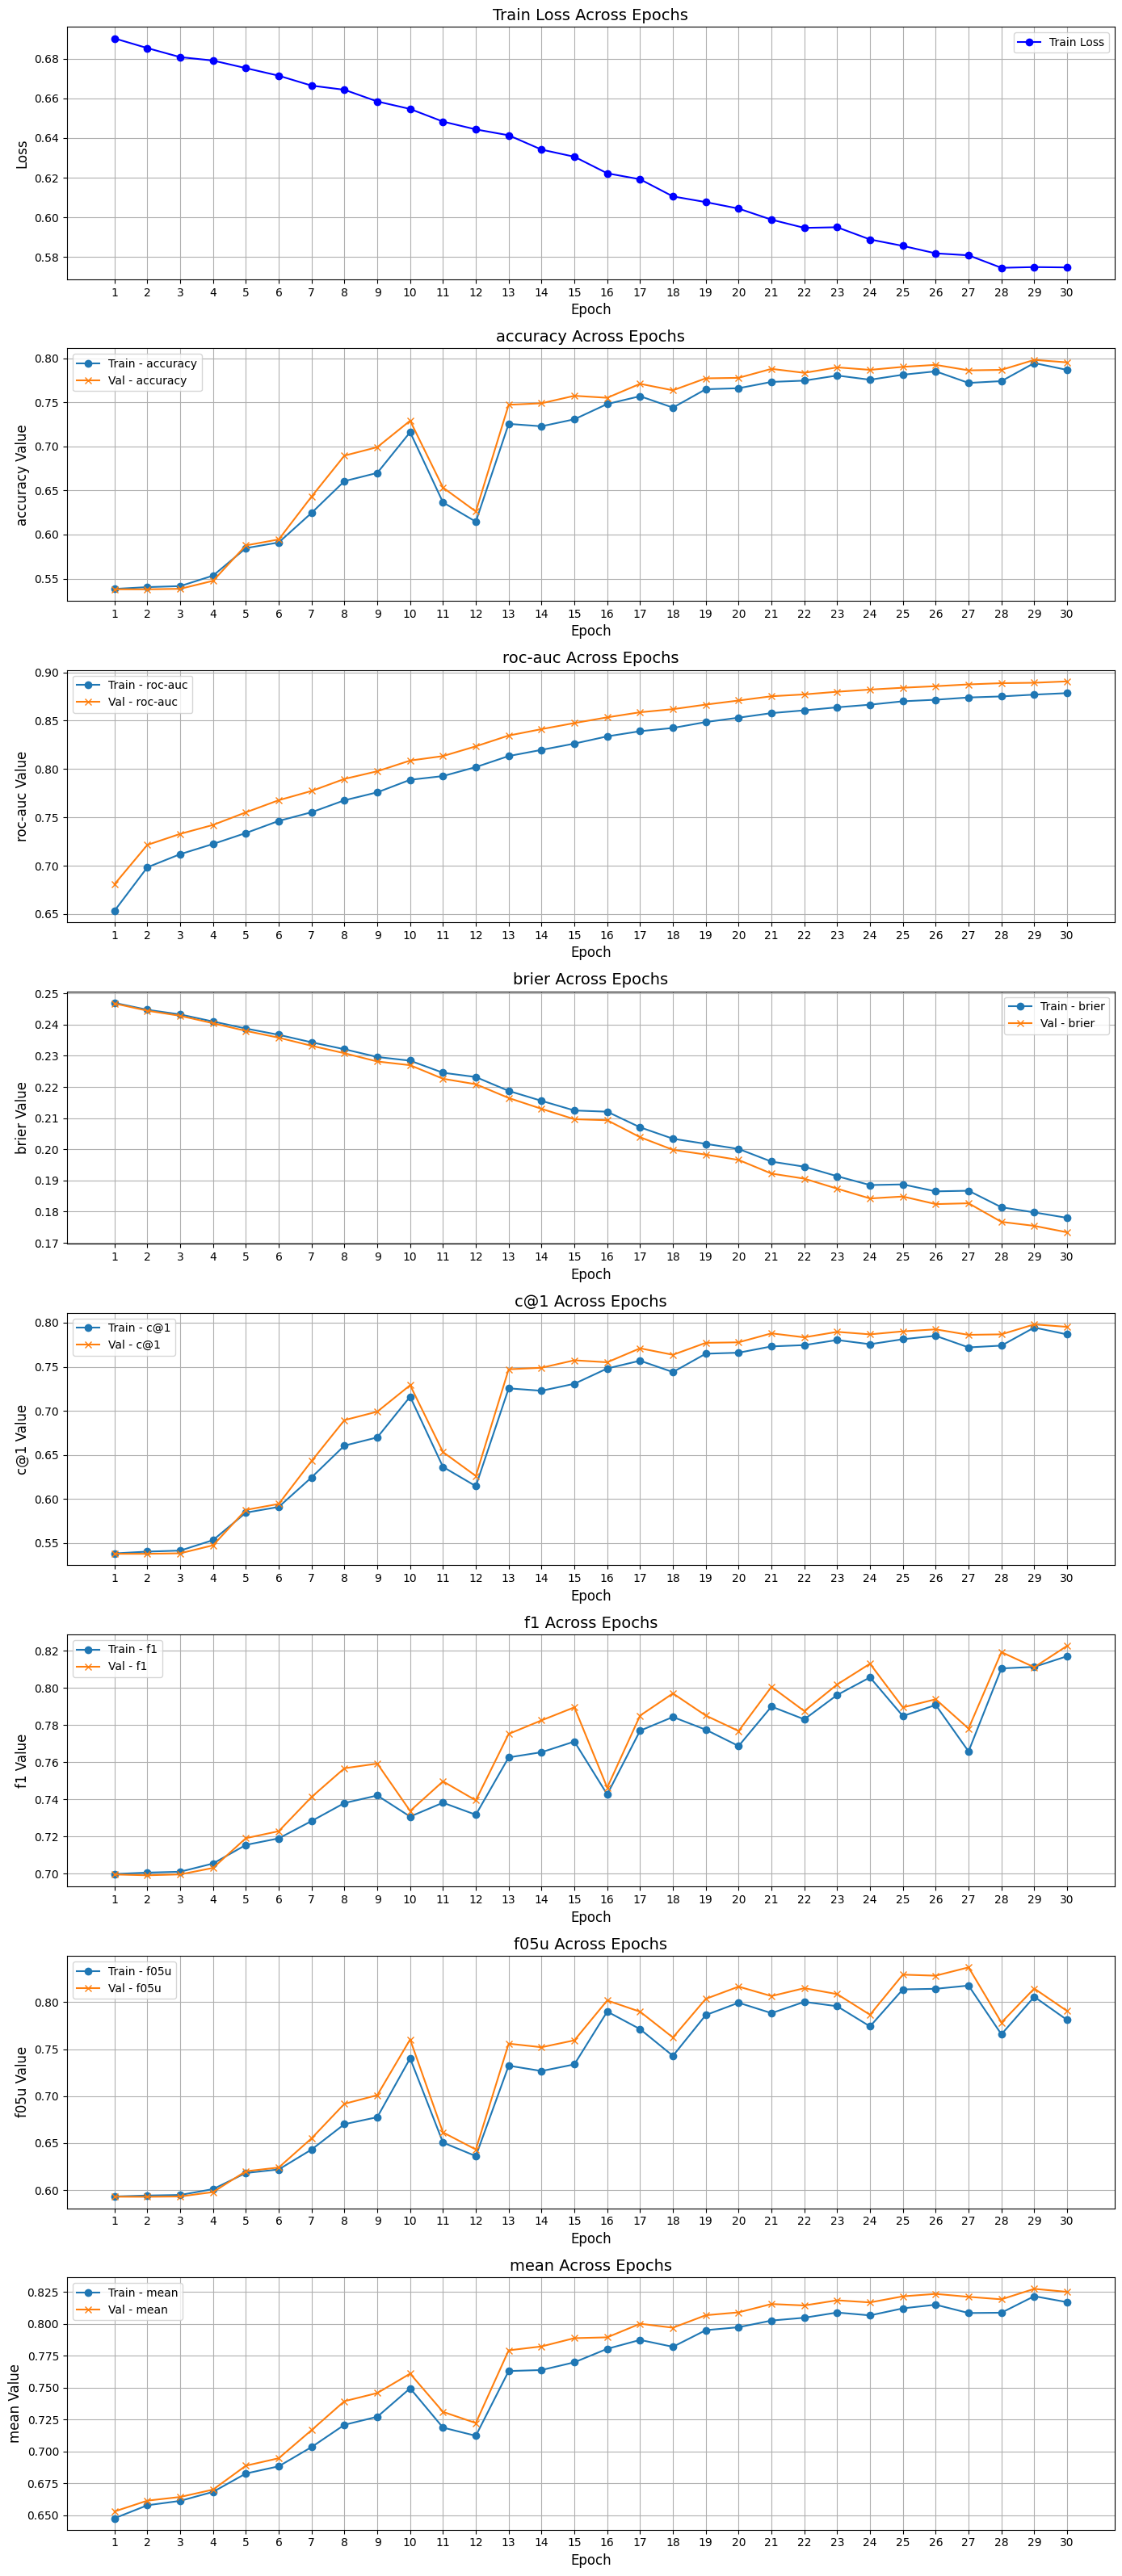

In [23]:
import matplotlib.pyplot as plt

metric_names = history["val_metrics"][0].keys()
epochs = list(range(1, len(history["val_metrics"]) + 1))

train_values = {name: [epoch.get(name, None) for epoch in history["train_metrics"]] for name in metric_names}
val_values = {name: [epoch.get(name, None) for epoch in history["val_metrics"]] for name in metric_names}

num_subplots = len(metric_names) + 1  # Number of metrics + train loss
plt.figure(figsize=(14, 4 * num_subplots))  # Increase height proportional to the number of plots

# Plot train loss
plt.subplot(num_subplots, 1, 1)

plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o", color="blue")
plt.title("Train Loss Across Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.xticks(epochs)
plt.grid(True)
plt.legend()

# Plotting each metric in a separate graph
for idx, metric in enumerate(metric_names):
    plt.subplot(len(metric_names) + 1, 1, idx + 2)  # Adjust index for additional loss plot
    plt.plot(epochs, train_values[metric], label=f'Train - {metric}', marker='o')
    plt.plot(epochs, val_values[metric], label=f'Val - {metric}', marker='x')
    plt.title(f"{metric} Across Epochs", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel(f"{metric} Value", fontsize=12)
    plt.xticks(epochs)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

## Evaluate test

In [26]:
model = torch.load('models/models_individual_concatenate_embeddings/bert-base/fine_tuned_model_30_epochs_3e-05_lr_0_layers_256_batch_size_checkpoint_29.pth')

In [27]:
# Evaluación final en el conjunto de prueba
train_accuracy = evaluate(model, train_loader, device)
print(f"Train Metrics: {train_accuracy}")
val_accuracy = evaluate(model, val_loader, device)
print(f"Val Metrics: {val_accuracy}")
test_accuracy = evaluate(model, test_loader, device)
print(f"Test Metrics: {test_accuracy}")

Train Metrics: {'accuracy': 0.7944941656281862, 'roc-auc': 0.8769163800223945, 'brier': 0.1797527311794952, 'c@1': 0.7944941656281862, 'f1': 0.8113953004782699, 'f05u': 0.8057654978730435, 'mean': 0.8217637225644797}
Val Metrics: {'accuracy': 0.7980769230769231, 'roc-auc': 0.8891768104300545, 'brier': 0.175429788915199, 'c@1': 0.7980769230769231, 'f1': 0.8112109994711793, 'f05u': 0.8145709430756158, 'mean': 0.8275211774277148}
Test Metrics: {'accuracy': 0.8127828054298643, 'roc-auc': 0.8892897692165102, 'brier': 0.1776394708152968, 'c@1': 0.8127828054298643, 'f1': 0.8258811152025248, 'f05u': 0.8266638584667227, 'mean': 0.8353956155000649}
